In [1]:
import os
import matplotlib.pyplot as plt
import random
from PIL import Image

In [2]:
dataset_path = "RGB_224x224"

In [3]:
train_dir = os.path.join(dataset_path,"train")

In [4]:
classes = os.listdir(train_dir)

In [5]:
len(classes)

139

In [6]:
classes

['Aji pepper plant',
 'Almonds plant',
 'Amaranth plant',
 'Apples plant',
 'Artichoke plant',
 'Avocados plant',
 'Bananas plant',
 'Barley plant',
 'Beets plant',
 'Black pepper plant',
 'Blueberries plant',
 'Bok choy plant',
 'Brazil nuts plant',
 'Broccoli plant',
 'Brussels sprout plant',
 'Buckwheat plant',
 'Cabbages and other brassicas plant',
 'Camucamu plant',
 'Carrots and turnips plant',
 'Cashew nuts plant',
 'Cassava plant',
 'Cauliflower plant',
 'Celery plant',
 'Cherimoya plant',
 'Cherry plant',
 'Chestnuts plant',
 'Chickpeas plant',
 'Chili peppers and green peppers plant',
 'Cinnamon plant',
 'Cloves plant',
 'Cocoa beans plant',
 'Coconuts plant',
 'Coffee (green) plant',
 'Collards plant',
 'Cotton lint plant',
 'Cranberries plant',
 'Cucumbers and gherkins plant',
 'Dates plant',
 'Dry beans plant',
 'Dry peas plant',
 'Durian plant',
 'Eggplants (Aubergines) plant',
 'Endive plant',
 'Fava bean plant',
 'Figs plant',
 'Flax fiber and tow plant',
 'Flaxseed (Li

In [7]:
random.sample(classes,5)

['Cassava plant',
 'Dates plant',
 'Radishes and similar roots plant',
 'Navy bean plant',
 'Olives plant']

In [8]:
def show_sample_images(num_classes = 4):
    fig,axes = plt.subplots(num_classes,5,figsize=(15,3*num_classes))
    for i, class_name in enumerate(random.sample(classes, num_classes)):
        class_path = os.path.join(train_dir,class_name)
        images = os.listdir(class_path)
        
        for j in range(5):
            img_path = os.path.join(class_path, images[j])
            img = Image.open(img_path)
            axes[i,j].imshow(img)
            axes[i,j].set_title(class_name)
            axes[i,j].axis("off")
    plt.tight_layout()

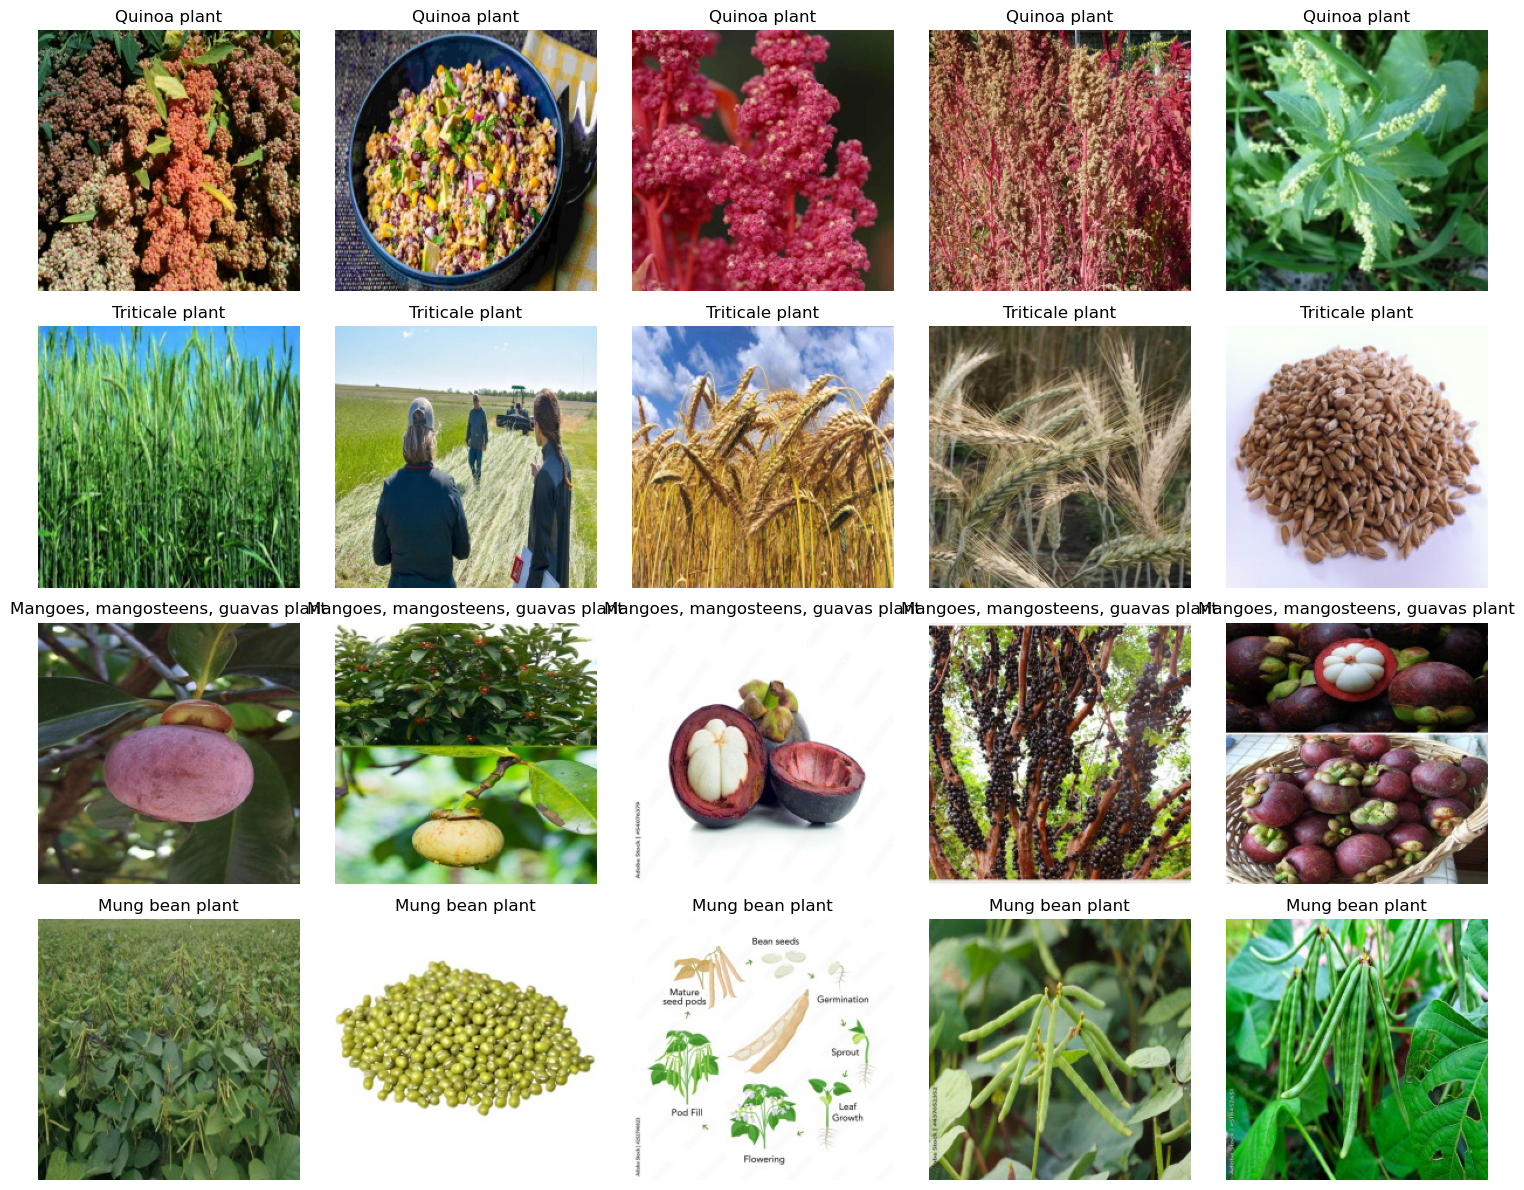

In [9]:
show_sample_images()

In [10]:
!pip install torch torchvision torchaudio

In [11]:
import torch 
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [12]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [13]:
train_dataset = ImageFolder(os.path.join(dataset_path,"train"),transform = transform)
val_dataset = ImageFolder(os.path.join(dataset_path,"val"),transform = transform)
test_dataset = ImageFolder(os.path.join(dataset_path,"test"),transform = transform)

In [14]:
train_loader = DataLoader(train_dataset, batch_size=128,shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [15]:
import torchvision.models as models
import torch.nn as nn

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
torch.backends.mps.is_available()

False

In [18]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [19]:
device

device(type='cpu')

In [20]:
model = models.resnet18(pretrained = True)

c:\Users\ripan\anaconda4\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ripan\anaconda4\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
for param in model.parameters():
    param.requires_grad = False

In [22]:
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

In [23]:
import torch.optim as optim
import torch.nn.functional as F

In [24]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [25]:
def train_one_epoch(model, loader):
    model.train()
    running_loss = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    return running_loss/len(loader)

In [26]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct/total

In [27]:
epochs = 5 

for epoch in range(epochs):
    train_loss = train_one_epoch(model, train_loader)
    val_acc =  evaluate(model, val_loader)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Accuracy: {val_acc:.4f}")

Epoch 1, Train Loss: 3.9260, Val Accuracy: 0.3496
Epoch 2, Train Loss: 2.9147, Val Accuracy: 0.4024
Epoch 3, Train Loss: 2.5917, Val Accuracy: 0.4366
Epoch 4, Train Loss: 2.4181, Val Accuracy: 0.4399
Epoch 5, Train Loss: 2.2923, Val Accuracy: 0.4539


In [28]:
test_acc = evaluate(model, test_loader)

In [29]:
print(f"Test Accuracy: {test_acc: .4f}")

Test Accuracy:  0.4527


In [30]:
def visualize_predictions(model, loader, n=5):
    model.eval()
    images_shown = 0
    class_names = train_dataset.classes
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            for i in range(n):
                img = images[i].cpu().permute(1,2,0).numpy()
                plt.imshow((img*0.229 + 0.485))
                plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[preds[i]]}")
                plt.axis("off")
                plt.show()
                
                images_shown += 1
                
                if images_shown >= n:
                    return

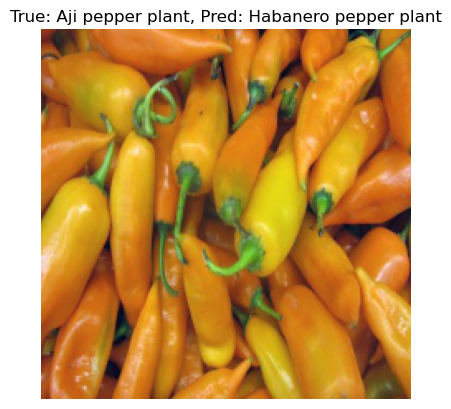

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


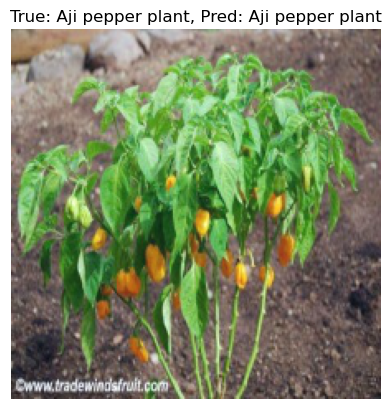

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


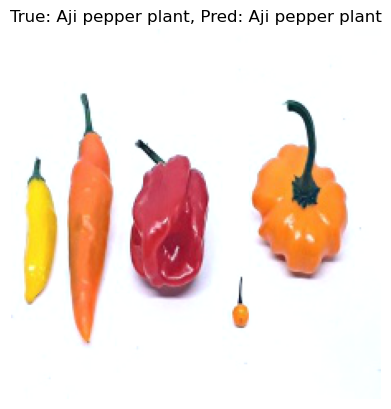

In [31]:
visualize_predictions(model, test_loader, 3)

In [32]:
import joblib

In [33]:
model_data = {
    "model_state_dict": model.state_dict(),
    "class_to_idx": train_dataset.class_to_idx
}

In [34]:
model_data

{'model_state_dict': OrderedDict([('conv1.weight',
               tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
                           1.7083e-02, -1.2694e-02],
                         [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
                          -1.2907e-01,  3.7424e-03],
                         [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
                           2.5632e-01,  6.3573e-02],
                         ...,
                         [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
                          -4.2058e-01, -2.5781e-01],
                         [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
                           3.9359e-01,  1.6606e-01],
                         [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
                          -8.2230e-02, -5.7828e-03]],
               
                        [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-

In [40]:
joblib.dump(model_data,"crop_classifier_model.pkl")

['crop_classifier_model.pkl']